In [ ]:
"""
Imports and Setup
"""

from __future__ import annotations

import logging
import json
import numpy as np
from pathlib import Path
from typing import Dict, List, Set, Tuple, Optional
from collections import defaultdict

import pandas as pd

# Project imports
from utils.paths import (
    PROJECT_ROOT,
    RAW_DATA,
    PREDICTIONS,
    GOLD_CLEAN,
    BNF_OCR,
    SCHEMAS,
    discover_all_extractions,
    detect_schema_family,
)
from utils.evaluation import (
    load_and_match_page,
    evaluate_order_agnostic,
    evaluate_structure_aware,
    evaluate_classification,
    evaluate_classification_detailed,
    evaluate_metadata_field,
    evaluate_continuation_all_items,
    calculate_word_coverage,
    calculate_character_coverage,
)
from utils.config import EVALUATION_CONFIG

# Logging configuration
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
)
logger = logging.getLogger("unified_evaluation")

# Matplotlib configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Unified Evaluation - Stage 1")
print("=" * 60)
print(f"Project root: {PROJECT_ROOT}")
print(f"Gold standard: {GOLD_CLEAN}")
print(f"BnF OCR: {BNF_OCR}")
print(f"Predictions: {PREDICTIONS / 'evaluations'}")

Unified Evaluation - Stage 1
Project root: /home/fabian-ramirez/Documents/These/Code/magazine_graphs
Gold standard: /home/fabian-ramirez/Documents/These/Code/magazine_graphs/data/gold_standard/cleaned
BnF OCR: /home/fabian-ramirez/Documents/These/Code/magazine_graphs/data/bnf_ocr
Predictions: /home/fabian-ramirez/Documents/These/Code/magazine_graphs/data/predictions/evaluations


In [2]:
"""
Mode Selection

Choose evaluation mode:
- 'auto': Run all available evaluations (recommended)
- 'general': General statistics only
- 'bag_of_words': General + bag-of-words evaluation
- 'structure_aware': All evaluations (requires gold standard with structure)
"""

MODE = "auto"  # "auto", "general", "bag_of_words", "structure_aware"

print("\n" + "=" * 60)
print(f"MODE: {MODE.upper()}")
print("=" * 60)

if MODE == "auto":
    print("\nAuto mode: Will run all available evaluations based on detected data")
elif MODE == "general":
    print("\nGeneral statistics only (no gold standard required)")
elif MODE == "bag_of_words":
    print("\nGeneral + bag-of-words evaluation (requires gold standard or BnF OCR)")
elif MODE == "structure_aware":
    print("\nFull structure-aware evaluation (requires gold standard with items)")
else:
    raise ValueError(f"Unknown mode: {MODE}. Use 'auto', 'general', 'bag_of_words', or 'structure_aware'")


MODE: AUTO

Auto mode: Will run all available evaluations based on detected data


In [4]:
"""
Configuration

Specify which extractions to evaluate and what metrics to calculate.
"""

# Magazines to evaluate (None = all available)
MAGAZINES = None  # or ["La_Plume_bpt6k1212187t_15-11-1893"]

# Metrics to calculate (for general statistics)
CALCULATE_METRICS = {
    'items_per_page': True,
    'empty_pages': True,
    'coverage': True,
    'classification_dist': True,
}

# Structure-aware evaluation dimensions (if available)
STRUCTURE_DIMENSIONS = {
    'structure_detection': True,
    'text_quality': True,
    'classification': True,
    'metadata': True,
    'continuation': True,  # Only if gold standard has continuation fields
}

# Similarity thresholds
SIMILARITY_THRESHOLD = EVALUATION_CONFIG.similarity_threshold  # 0.7 for item matching
METADATA_THRESHOLD = 0.8  # For metadata partial matches


print("\nConfiguration:")
print(f"  Magazines: {MAGAZINES if MAGAZINES else 'All available'}")
print(f"  Similarity threshold: {SIMILARITY_THRESHOLD}")
print(f"  Metadata threshold: {METADATA_THRESHOLD}")
     


Configuration:
  Magazines: All available
  Similarity threshold: 0.7
  Metadata threshold: 0.8


In [5]:
"""
Data Discovery

Find all available extractions, gold standards, and BnF OCR data.
"""

print("\n" + "=" * 60)
print("DATA DISCOVERY")
print("=" * 60)
print()

# Discover all extractions
eval_base = PREDICTIONS / "evaluations"
if eval_base.exists():
    all_extractions = discover_all_extractions(eval_base)
    print(f"Found {len(all_extractions)} extraction(s) in {eval_base}")
else:
    all_extractions = []
    print(f"WARNING:  No extractions found in {eval_base}")

# Filter by selected magazines if specified
if MAGAZINES:
    all_extractions = [e for e in all_extractions if e['magazine_name'] in MAGAZINES]
    print(f"Filtered to {len(all_extractions)} extraction(s) for selected magazines")

# Group by magazine for display
extractions_by_magazine = defaultdict(list)
for extraction in all_extractions:
    mag = extraction['magazine_name']
    extractions_by_magazine[mag].append({
        'model': extraction['model_name'],
        'schema': extraction['schema_name'],
        'prompt': extraction['prompt_name'],
        'path': extraction['path'],
        'num_files': extraction['num_files']
    })

print()
print("Extractions by magazine:")
for mag, exts in sorted(extractions_by_magazine.items()):
    print(f"\n  {mag}: {len(exts)} extraction(s)")
    for ext in exts[:3]:  # Show first 3
        prompt_str = ext['prompt'] or 'none'
        print(f"    - {ext['model']} × {ext['schema']} × {prompt_str} ({ext['num_files']} files)")
    if len(exts) > 3:
        print(f"    ... and {len(exts) - 3} more")

# Discover gold standards
gold_magazines = {}
if GOLD_CLEAN.exists():
    for mag_dir in GOLD_CLEAN.iterdir():
        if mag_dir.is_dir():
            json_files = list(mag_dir.glob("*.json"))
            if json_files:
                gold_magazines[mag_dir.name] = {
                    'path': mag_dir,
                    'num_files': len(json_files)
                }
    print(f"\n\nGold standard data:")
    print(f"  Found {len(gold_magazines)} magazine(s) with gold annotations")
    for mag, info in sorted(gold_magazines.items()):
        print(f"    - {mag}: {info['num_files']} file(s)")
else:
    print(f"\nWARNING:  Gold standard directory not found: {GOLD_CLEAN}")

# Discover BnF OCR data
bnf_magazines = {}
if BNF_OCR.exists():
    for mag_dir in BNF_OCR.iterdir():
        if mag_dir.is_dir():
            txt_files = list(mag_dir.glob("*.txt"))
            if txt_files:
                bnf_magazines[mag_dir.name] = {
                    'path': mag_dir,
                    'num_files': len(txt_files)
                }
    print(f"\n\nBnF OCR data:")
    print(f"  Found {len(bnf_magazines)} magazine(s) with BnF OCR")
    for mag, info in sorted(bnf_magazines.items()):
        print(f"    - {mag}: {info['num_files']} file(s)")
else:
    print(f"\nWARNING:  BnF OCR directory not found: {BNF_OCR}")


DATA DISCOVERY

Found 3 extraction(s) in /home/fabian-ramirez/Documents/These/Code/magazine_graphs/data/predictions/evaluations

Extractions by magazine:

  La_Plume_bpt6k1185893k_1_10_1889: 3 extraction(s)
    - mistral-ocr-latest × stage1_page × none (14 files)
    - mistral-ocr-latest × stage1_page_v2 × none (14 files)
    - mistral-ocr-latest × stage1_page_v2_medium × none (9 files)


Gold standard data:
  Found 2 magazine(s) with gold annotations
    - La_Plume_bpt6k1185893k_1_10_1889: 14 file(s)
    - La_Plume_bpt6k1212187t_15-11-1893: 34 file(s)


BnF OCR data:
  Found 1 magazine(s) with BnF OCR
    - La_Plume_bpt6k1212187t_15-11-1893: 34 file(s)


In [6]:
"""
Capability Detection

Auto-detect what evaluations are possible for each magazine.
"""

print("\n" + "=" * 60)
print("CAPABILITY DETECTION")
print("=" * 60)
print()

# Check what's available for each magazine with extractions
capabilities = {}

for mag_name in extractions_by_magazine.keys():
    cap = {
        'has_extractions': True,
        'has_gold': mag_name in gold_magazines,
        'has_bnf': mag_name in bnf_magazines,
        'has_structure': False,
        'has_continuation': False,
    }
    
    # If gold standard exists, check what fields it has
    if cap['has_gold']:
        gold_path = gold_magazines[mag_name]['path']
        # Load first JSON file to check structure
        first_json = next(gold_path.glob("*.json"), None)
        if first_json:
            try:
                with open(first_json, 'r', encoding='utf-8') as f:
                    gold_data = json.load(f)
                
                # Check if it has items (structure)
                if 'items' in gold_data and len(gold_data['items']) > 0:
                    cap['has_structure'] = True
                    
                    # Check if items have continuation fields
                    first_item = gold_data['items'][0]
                    if 'is_continuation' in first_item or 'continues_on_next_page' in first_item:
                        cap['has_continuation'] = True
            except Exception as e:
                logger.warning(f"Could not check gold standard structure for {mag_name}: {e}")
    
    # Determine available evaluation types
    cap['can_general'] = True  # Always possible
    cap['can_bag_of_words'] = cap['has_gold'] or cap['has_bnf']
    cap['can_structure_aware'] = cap['has_gold'] and cap['has_structure']
    
    capabilities[mag_name] = cap

# Display capabilities
print("Evaluation capabilities per magazine:\n")
print(f"{'Magazine':<40} {'General':<10} {'Bag-of-Words':<15} {'Structure-Aware':<17} {'Continuation'}")
print("-" * 100)

for mag_name, cap in sorted(capabilities.items()):
    general = "✓" if cap['can_general'] else "✗"
    bow = "✓" if cap['can_bag_of_words'] else "✗"
    struct = "✓" if cap['can_structure_aware'] else "✗"
    cont = "✓" if cap['has_continuation'] else "✗"
    
    print(f"{mag_name:<40} {general:<10} {bow:<15} {struct:<17} {cont}")

print()
print("Legend:")
print("  General: Internal quality metrics (always available)")
print("  Bag-of-Words: Text-level comparison (requires gold or BnF)")
print("  Structure-Aware: Item-level evaluation (requires gold with items)")
print("  Continuation: Continuation field evaluation (requires continuation fields in gold)")


CAPABILITY DETECTION

Evaluation capabilities per magazine:

Magazine                                 General    Bag-of-Words    Structure-Aware   Continuation
----------------------------------------------------------------------------------------------------
La_Plume_bpt6k1185893k_1_10_1889         ✓          ✓               ✓                 ✗

Legend:
  General: Internal quality metrics (always available)
  Bag-of-Words: Text-level comparison (requires gold or BnF)
  Structure-Aware: Item-level evaluation (requires gold with items)
  Continuation: Continuation field evaluation (requires continuation fields in gold)


In [7]:
"""
Evaluation Preview

Display what evaluations will run based on mode and available data.
"""

print("\n" + "=" * 60)
print("EVALUATION PREVIEW")
print("=" * 60)
print()

# Determine what will run based on MODE
will_run = {
    'general': False,
    'bag_of_words': False,
    'structure_aware': False,
}

if MODE == "auto":
    # Run everything possible
    will_run['general'] = any(cap['can_general'] for cap in capabilities.values())
    will_run['bag_of_words'] = any(cap['can_bag_of_words'] for cap in capabilities.values())
    will_run['structure_aware'] = any(cap['can_structure_aware'] for cap in capabilities.values())
elif MODE == "general":
    will_run['general'] = True
elif MODE == "bag_of_words":
    will_run['general'] = True
    will_run['bag_of_words'] = any(cap['can_bag_of_words'] for cap in capabilities.values())
elif MODE == "structure_aware":
    will_run['general'] = True
    will_run['bag_of_words'] = any(cap['can_bag_of_words'] for cap in capabilities.values())
    will_run['structure_aware'] = any(cap['can_structure_aware'] for cap in capabilities.values())

print("Evaluations to run:\n")
print(f"  1. General Statistics:       {'✓ Will run' if will_run['general'] else '✗ Skipped'}")
print(f"  2. Bag-of-Words:              {'✓ Will run' if will_run['bag_of_words'] else '✗ Skipped (no gold/BnF data)'}")
print(f"  3. Structure-Aware:           {'✓ Will run' if will_run['structure_aware'] else '✗ Skipped (no gold structure)'}")

print()
print(f"Total extractions to evaluate: {len(all_extractions)}")
print(f"Magazines: {len(capabilities)}")

if not any(will_run.values()):
    print("\nWARNING: No evaluations will run!")
    print("   - Check that extractions exist in data/predictions/evaluations/")
    print("   - For bag-of-words or structure-aware, add gold standard data")


EVALUATION PREVIEW

Evaluations to run:

  1. General Statistics:       ✓ Will run
  2. Bag-of-Words:              ✓ Will run
  3. Structure-Aware:           ✓ Will run

Total extractions to evaluate: 3
Magazines: 1


In [8]:
"""
Execute: General Statistics

Calculate internal quality metrics for all extractions (no gold standard needed).
"""

general_results = []

if will_run['general']:
    print("\n" + "=" * 60)
    print("RUNNING: GENERAL STATISTICS")
    print("=" * 60)
    print()
    
    for extraction in all_extractions:
        mag = extraction['magazine_name']
        model = extraction['model_name']
        schema = extraction['schema_name']
        prompt = extraction['prompt_name']
        path = extraction['path']
        
        print(f"Evaluating: {mag} / {model} / {schema} / {prompt or 'none'}")
        
        # Load all JSON files from this extraction
        json_files = sorted(path.glob("*.json"))
        
        items_per_page = []
        empty_pages = 0
        total_chars = 0
        total_words = 0
        total_items = 0
        class_counts = defaultdict(int)
        validation_errors = 0
        
        for json_file in json_files:
            try:
                with open(json_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                items = data.get('items', [])
                num_items = len(items)
                items_per_page.append(num_items)
                
                if num_items == 0:
                    empty_pages += 1
                
                total_items += num_items
                
                # Count chars, words, classes
                for item in items:
                    text = item.get('item_text_raw', '')
                    total_chars += len(text)
                    total_words += len(text.split())
                    
                    item_class = item.get('item_class', 'unknown')
                    class_counts[item_class] += 1
                    
            except Exception as e:
                validation_errors += 1
                logger.warning(f"Error processing {json_file.name}: {e}")
        
        # Calculate statistics
        num_pages = len(json_files)
        avg_items = sum(items_per_page) / num_pages if num_pages > 0 else 0
        median_items = sorted(items_per_page)[num_pages // 2] if num_pages > 0 else 0
        
        general_results.append({
            'magazine': mag,
            'model': model,
            'schema': schema,
            'prompt': prompt,
            'num_pages': num_pages,
            'total_items': total_items,
            'avg_items_per_page': avg_items,
            'median_items_per_page': median_items,
            'empty_pages': empty_pages,
            'empty_page_rate': empty_pages / num_pages if num_pages > 0 else 0,
            'total_chars': total_chars,
            'total_words': total_words,
            'avg_chars_per_page': total_chars / num_pages if num_pages > 0 else 0,
            'avg_words_per_page': total_words / num_pages if num_pages > 0 else 0,
            'class_distribution': dict(class_counts),
            'validation_errors': validation_errors,
        })
        
        print(f"  Pages: {num_pages}, Items: {total_items}, Avg/page: {avg_items:.1f}, Empty: {empty_pages}")
    
    print(f"\n✓ General statistics complete for {len(general_results)} extraction(s)")
else:
    print("\nSkipping general statistics (mode={MODE})")


RUNNING: GENERAL STATISTICS

Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page / none
  Pages: 14, Items: 62, Avg/page: 4.4, Empty: 1
Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page_v2 / none
  Pages: 14, Items: 74, Avg/page: 5.3, Empty: 1
Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page_v2_medium / none
  Pages: 9, Items: 33, Avg/page: 3.7, Empty: 1

✓ General statistics complete for 3 extraction(s)


In [9]:
"""
Execute: Bag-of-Words Evaluation

Text-level comparison using order-agnostic metrics (CER/WER).
Also calculates word and character coverage with precision/recall/F1 (from 01d).
Runs if gold standard or BnF OCR data is available.
"""

bow_results = []

if will_run['bag_of_words']:
    print("\n" + "=" * 60)
    print("RUNNING: BAG-OF-WORDS EVALUATION")
    print("=" * 60)
    print()

    for extraction in all_extractions:
        mag = extraction['magazine_name']
        model = extraction['model_name']
        schema = extraction['schema_name']
        prompt = extraction['prompt_name']
        path = extraction['path']

        # Skip if no gold/BnF for this magazine
        if not capabilities[mag]['can_bag_of_words']:
            continue

        print(f"Evaluating: {mag} / {model} / {schema} / {prompt or 'none'}")

        # Use gold standard if available, otherwise BnF
        if capabilities[mag]['has_gold']:
            gold_path = gold_magazines[mag]['path']
            reference_source = "gold"
        else:
            gold_path = bnf_magazines[mag]['path']
            reference_source = "bnf"

        # Load all pages and run order-agnostic evaluation
        json_files = sorted(path.glob("*.json"))

        page_metrics = []
        word_coverage_pages = []
        char_coverage_pages = []

        for json_file in json_files:
            page_name = json_file.stem

            # Find corresponding gold/BnF file
            if reference_source == "gold":
                ref_file = gold_path / f"{page_name}.json"
                if not ref_file.exists():
                    continue

                with open(ref_file, 'r', encoding='utf-8') as f:
                    ref_data = json.load(f)
                ref_items = ref_data.get('items', [])
            else:
                ref_file = gold_path / f"{page_name}.txt"
                if not ref_file.exists():
                    continue

                ref_text = ref_file.read_text(encoding='utf-8')
                ref_items = [{'item_text_raw': ref_text}]

            # Load prediction
            with open(json_file, 'r', encoding='utf-8') as f:
                pred_data = json.load(f)
            pred_items = pred_data.get('items', [])

            # Run order-agnostic evaluation (CER/WER)
            try:
                metrics = evaluate_order_agnostic(ref_items, pred_items)
                page_metrics.append(metrics)

                # Calculate word and character coverage (from 01d)
                # Concatenate all item text for bag-of-words comparison
                ref_text_combined = ' '.join(item.get('item_text_raw', '') for item in ref_items)
                pred_text_combined = ' '.join(item.get('item_text_raw', '') for item in pred_items)

                # Word coverage with P/R/F1
                word_metrics = calculate_word_coverage(
                    reference=ref_text_combined,
                    hypothesis=pred_text_combined,
                    normalization='standard'
                )
                word_coverage_pages.append(word_metrics)

                # Character coverage with frequency (letters only normalization)
                char_metrics = calculate_character_coverage(
                    reference=ref_text_combined,
                    hypothesis=pred_text_combined,
                    normalization='letters_only'
                )
                char_coverage_pages.append(char_metrics)

            except Exception as e:
                logger.warning(f"Bag-of-words evaluation failed for {page_name}: {e}")

        # Aggregate across pages
        if page_metrics:
            # CER/WER metrics
            avg_cer_standard = sum(m['cer_standard'] for m in page_metrics) / len(page_metrics)
            avg_wer_standard = sum(m['wer_standard'] for m in page_metrics) / len(page_metrics)
            avg_cer_letters = sum(m['cer_letters'] for m in page_metrics) / len(page_metrics)

            result = {
                'magazine': mag,
                'model': model,
                'schema': schema,
                'prompt': prompt,
                'reference_source': reference_source,
                'num_pages': len(page_metrics),
                'cer_standard': avg_cer_standard,
                'wer_standard': avg_wer_standard,
                'cer_letters': avg_cer_letters,
            }

            # Word coverage metrics (from 01d)
            if word_coverage_pages:
                avg_word_precision = sum(m['precision'] for m in word_coverage_pages) / len(word_coverage_pages)
                avg_word_recall = sum(m['recall'] for m in word_coverage_pages) / len(word_coverage_pages)
                avg_word_f1 = sum(m['f1'] for m in word_coverage_pages) / len(word_coverage_pages)
                avg_shared_words = sum(m['shared_words'] for m in word_coverage_pages) / len(word_coverage_pages)
                avg_unique_hyp = sum(m['unique_to_hyp'] for m in word_coverage_pages) / len(word_coverage_pages)
                avg_unique_ref = sum(m['unique_to_ref'] for m in word_coverage_pages) / len(word_coverage_pages)

                result.update({
                    'word_precision': avg_word_precision,
                    'word_recall': avg_word_recall,
                    'word_f1': avg_word_f1,
                    'avg_shared_words': avg_shared_words,
                    'avg_unique_to_hyp': avg_unique_hyp,
                    'avg_unique_to_ref': avg_unique_ref,
                })

            # Character coverage metrics (from 01d)
            if char_coverage_pages:
                avg_char_precision = sum(m['precision'] for m in char_coverage_pages) / len(char_coverage_pages)
                avg_char_recall = sum(m['recall'] for m in char_coverage_pages) / len(char_coverage_pages)
                avg_char_f1 = sum(m['f1'] for m in char_coverage_pages) / len(char_coverage_pages)

                result.update({
                    'char_precision': avg_char_precision,
                    'char_recall': avg_char_recall,
                    'char_f1': avg_char_f1,
                })

            bow_results.append(result)

            # Display key metrics
            print(f"  Pages: {len(page_metrics)}, CER: {avg_cer_standard:.3f}, WER: {avg_wer_standard:.3f}", end="")
            if 'word_f1' in result:
                print(f", Word F1: {result['word_f1']:.3f}", end="")
            if 'char_f1' in result:
                print(f", Char F1: {result['char_f1']:.3f}", end="")
            print()

    print(f"\n✓ Bag-of-words evaluation complete for {len(bow_results)} extraction(s)")
else:
    print("\nSkipping bag-of-words evaluation (no gold/BnF data available)")


RUNNING: BAG-OF-WORDS EVALUATION

Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page / none
  Pages: 14, CER: 0.102, WER: 0.134, Word F1: 0.913, Char F1: 0.967
Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page_v2 / none
  Pages: 14, CER: 0.101, WER: 0.149, Word F1: 0.899, Char F1: 0.969
Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page_v2_medium / none
  Pages: 9, CER: 0.124, WER: 0.152, Word F1: 0.915, Char F1: 0.952

✓ Bag-of-words evaluation complete for 3 extraction(s)


In [16]:
"""
Execute: Structure-Aware Evaluation

Item-level evaluation with matching algorithm (5 dimensions).
Uses detailed classification with per-class metrics and confusion matrix (from 01c).
Runs only if gold standard with structure is available.
"""

structure_results = []

if will_run['structure_aware']:
    print("\n" + "=" * 60)
    print("RUNNING: STRUCTURE-AWARE EVALUATION")
    print("=" * 60)
    print()

    for extraction in all_extractions:
        mag = extraction['magazine_name']
        model = extraction['model_name']
        schema = extraction['schema_name']
        prompt = extraction['prompt_name']
        path = extraction['path']

        # Skip if no gold structure for this magazine
        if not capabilities[mag]['can_structure_aware']:
            continue

        print(f"Evaluating: {mag} / {model} / {schema} / {prompt or 'none'}")

        gold_path = gold_magazines[mag]['path']
        json_files = sorted(path.glob("*.json"))

        # Aggregate metrics across pages
        all_matches = []
        all_gold_items = []
        all_pred_items = []
        all_unmatched_gold = []
        all_unmatched_pred = []

        text_quality_pages = []
        classification_pages = []
        metadata_title_pages = []
        metadata_author_pages = []
        continuation_pages = []

        for json_file in json_files:
            page_name = json_file.name
            gold_file = gold_path / page_name

            if not gold_file.exists():
                continue

            try:
                # Load and match page
                page_data = load_and_match_page(
                    gold_file, json_file,
                    similarity_threshold=SIMILARITY_THRESHOLD
                )

                gold_items = page_data['gold_items']
                pred_items = page_data['pred_items']
                matches = page_data['matches']
                unmatched_gold = page_data['unmatched_gold']
                unmatched_pred = page_data['unmatched_pred']

                all_gold_items.extend(gold_items)
                all_pred_items.extend(pred_items)
                all_matches.extend([(g_idx + len(all_gold_items) - len(gold_items), 
                                     p_idx + len(all_pred_items) - len(pred_items), 
                                     score) 
                                    for g_idx, p_idx, score in matches])

                # Evaluate dimensions if enabled
                if STRUCTURE_DIMENSIONS['text_quality']:
                    sa_metrics = evaluate_structure_aware(gold_items, pred_items, matches)
                    text_quality_pages.append(sa_metrics)

                if STRUCTURE_DIMENSIONS['classification']:
                    # Use detailed classification (from 01c) - skip for now, will aggregate later
                    class_metrics = evaluate_classification(gold_items, pred_items, matches)
                    classification_pages.append(class_metrics)

                if STRUCTURE_DIMENSIONS['metadata']:
                    title_metrics = evaluate_metadata_field(
                        gold_items, pred_items, matches,
                        'item_title', METADATA_THRESHOLD
                    )
                    author_metrics = evaluate_metadata_field(
                        gold_items, pred_items, matches,
                        'item_author', METADATA_THRESHOLD
                    )
                    metadata_title_pages.append(title_metrics)
                    metadata_author_pages.append(author_metrics)

                if STRUCTURE_DIMENSIONS['continuation'] and capabilities[mag]['has_continuation']:
                    cont_metrics = evaluate_continuation_all_items(
                        gold_items, pred_items, matches,
                        unmatched_gold, unmatched_pred
                    )
                    continuation_pages.append(cont_metrics)

            except Exception as e:
                logger.warning(f"Structure-aware evaluation failed for {page_name}: {e}")

        # Aggregate results
        result = {
            'magazine': mag,
            'model': model,
            'schema': schema,
            'prompt': prompt,
            'num_pages': len(json_files),
        }

        # Structure detection
        if STRUCTURE_DIMENSIONS['structure_detection']:
            total_gold = len(all_gold_items)
            total_pred = len(all_pred_items)
            total_matched = len(all_matches)

            precision = total_matched / total_pred if total_pred > 0 else 0
            recall = total_matched / total_gold if total_gold > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            result['total_gold_items'] = total_gold
            result['total_pred_items'] = total_pred
            result['total_matched_items'] = total_matched
            result['structure_precision'] = precision
            result['structure_recall'] = recall
            result['structure_f1'] = f1

        # Text quality (standard normalization)
        if text_quality_pages:
            result['cer_structure_aware'] = sum(p['cer_standard'] for p in text_quality_pages) / len(text_quality_pages)
            result['wer_structure_aware'] = sum(p['wer_standard'] for p in text_quality_pages) / len(text_quality_pages)

        # Classification - use detailed evaluation with per-class metrics (from 01c)
        if STRUCTURE_DIMENSIONS['classification'] and all_gold_items and all_pred_items:
            # Collect all unique class labels
            all_classes = set()
            for item in all_gold_items + all_pred_items:
                all_classes.add(item.get('item_class', 'unknown'))
            class_labels = sorted(list(all_classes))

            # Run detailed classification evaluation
            try:
                detailed_class = evaluate_classification_detailed(
                    all_gold_items, all_pred_items, all_matches, class_labels
                )

                result['classification_accuracy'] = detailed_class['overall_accuracy']
                result['classification_per_class'] = detailed_class['per_class']
                result['confusion_matrix'] = detailed_class['confusion_matrix'].tolist()  # Convert numpy to list
                result['class_labels'] = detailed_class['class_labels']
                result['macro_avg_precision'] = detailed_class['macro_avg']['precision']
                result['macro_avg_recall'] = detailed_class['macro_avg']['recall']
                result['macro_avg_f1'] = detailed_class['macro_avg']['f1']
                result['weighted_avg_precision'] = detailed_class['weighted_avg']['precision']
                result['weighted_avg_recall'] = detailed_class['weighted_avg']['recall']
                result['weighted_avg_f1'] = detailed_class['weighted_avg']['f1']
            except Exception as e:
                logger.warning(f"Detailed classification failed for {mag}: {e}")
                # Fallback to simple classification accuracy
                if classification_pages:
                    total_correct = sum(p['correct'] for p in classification_pages)
                    total_items = sum(p['total'] for p in classification_pages)
                    result['classification_accuracy'] = total_correct / total_items if total_items > 0 else 0

        # Metadata
        if metadata_title_pages:
            avg_title_f1 = sum(p['f1'] for p in metadata_title_pages) / len(metadata_title_pages)
            result['metadata_title_f1'] = avg_title_f1
        if metadata_author_pages:
            avg_author_f1 = sum(p['f1'] for p in metadata_author_pages) / len(metadata_author_pages)
            result['metadata_author_f1'] = avg_author_f1

        # Continuation
        if continuation_pages:
            avg_is_cont_f1 = sum(p['is_continuation']['f1'] for p in continuation_pages) / len(continuation_pages)
            avg_continues_f1 = sum(p['continues_on_next_page']['f1'] for p in continuation_pages) / len(continuation_pages)
            result['continuation_is_f1'] = avg_is_cont_f1
            result['continuation_continues_f1'] = avg_continues_f1

        structure_results.append(result)

        # Display key metrics
        print(f"  Pages: {result['num_pages']}", end="")
        if 'structure_f1' in result:
            print(f", Structure F1: {result['structure_f1']:.3f}", end="")
        if 'cer_structure_aware' in result:
            print(f", CER: {result['cer_structure_aware']:.3f}", end="")
        if 'classification_accuracy' in result:
            print(f", Class Acc: {result['classification_accuracy']:.3f}", end="")
        print()

    print(f"\n✓ Structure-aware evaluation complete for {len(structure_results)} extraction(s)")
else:
    print("\nSkipping structure-aware evaluation (no gold structure available)")


RUNNING: STRUCTURE-AWARE EVALUATION

Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page / none
  Pages: 14, Structure F1: 0.515, CER: 0.145, Class Acc: 0.882
Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page_v2 / none
  Pages: 14, Structure F1: 0.778, CER: 0.041, Class Acc: 0.786
Evaluating: La_Plume_bpt6k1185893k_1_10_1889 / mistral-ocr-latest / stage1_page_v2_medium / none
  Pages: 9, Structure F1: 0.592, CER: 0.042, Class Acc: 1.000

✓ Structure-aware evaluation complete for 3 extraction(s)


In [11]:
"""
BnF OCR Comparison (from 01d)

Direct comparison of Mistral OCR vs BnF OCR text quality.
Shows side-by-side performance when both are available.
"""

bnf_comparison_results = []

# Only run if we have BnF data
has_bnf_data = any(capabilities[mag]['has_bnf'] for mag in capabilities.keys())

if has_bnf_data and will_run['bag_of_words']:
    print("\n" + "=" * 60)
    print("BnF OCR COMPARISON")
    print("=" * 60)
    print()
    
    # Find Mistral OCR extractions
    mistral_extractions = [
        e for e in all_extractions 
        if 'ocr' in e['model_name'].lower() and 'mistral' in e['model_name'].lower()
    ]
    
    if mistral_extractions:
        for extraction in mistral_extractions:
            mag = extraction['magazine_name']
            
            # Skip if no BnF for this magazine
            if not capabilities[mag]['has_bnf']:
                continue
            
            print(f"Comparing Mistral OCR vs BnF OCR for: {mag}")
            
            model = extraction['model_name']
            schema = extraction['schema_name']
            prompt = extraction['prompt_name']
            mistral_path = extraction['path']
            bnf_path = bnf_magazines[mag]['path']
            
            # Load all pages
            json_files = sorted(mistral_path.glob("*.json"))
            
            page_comparisons = []
            
            for json_file in json_files:
                page_name = json_file.stem
                bnf_file = bnf_path / f"{page_name}.txt"
                
                if not bnf_file.exists():
                    continue
                
                # Load Mistral OCR
                with open(json_file, 'r', encoding='utf-8') as f:
                    mistral_data = json.load(f)
                mistral_items = mistral_data.get('items', [])
                mistral_text = ' '.join(item.get('item_text_raw', '') for item in mistral_items)
                
                # Load BnF OCR
                bnf_text = bnf_file.read_text(encoding='utf-8')
                
                # Calculate metrics
                try:
                    # Word coverage
                    word_metrics = calculate_word_coverage(
                        reference=bnf_text,
                        hypothesis=mistral_text,
                        normalization='standard'
                    )
                    
                    # Character coverage
                    char_metrics = calculate_character_coverage(
                        reference=bnf_text,
                        hypothesis=mistral_text,
                        normalization='letters_only'
                    )
                    
                    page_comparisons.append({
                        'page': page_name,
                        'word_precision': word_metrics['precision'],
                        'word_recall': word_metrics['recall'],
                        'word_f1': word_metrics['f1'],
                        'char_precision': char_metrics['precision'],
                        'char_recall': char_metrics['recall'],
                        'char_f1': char_metrics['f1'],
                        'shared_words': word_metrics['shared_words'],
                        'mistral_unique_words': word_metrics['unique_to_hyp'],
                        'bnf_unique_words': word_metrics['unique_to_ref'],
                        'mistral_word_count': word_metrics['total_hyp_words'],
                        'bnf_word_count': word_metrics['total_ref_words'],
                    })
                except Exception as e:
                    logger.warning(f"BnF comparison failed for {page_name}: {e}")
            
            # Aggregate across pages
            if page_comparisons:
                avg_word_f1 = sum(p['word_f1'] for p in page_comparisons) / len(page_comparisons)
                avg_char_f1 = sum(p['char_f1'] for p in page_comparisons) / len(page_comparisons)
                avg_word_precision = sum(p['word_precision'] for p in page_comparisons) / len(page_comparisons)
                avg_word_recall = sum(p['word_recall'] for p in page_comparisons) / len(page_comparisons)
                avg_char_precision = sum(p['char_precision'] for p in page_comparisons) / len(page_comparisons)
                avg_char_recall = sum(p['char_recall'] for p in page_comparisons) / len(page_comparisons)
                
                total_shared = sum(p['shared_words'] for p in page_comparisons)
                total_mistral_unique = sum(p['mistral_unique_words'] for p in page_comparisons)
                total_bnf_unique = sum(p['bnf_unique_words'] for p in page_comparisons)
                
                bnf_comparison_results.append({
                    'magazine': mag,
                    'mistral_model': model,
                    'schema': schema,
                    'num_pages': len(page_comparisons),
                    'word_f1': avg_word_f1,
                    'word_precision': avg_word_precision,
                    'word_recall': avg_word_recall,
                    'char_f1': avg_char_f1,
                    'char_precision': avg_char_precision,
                    'char_recall': avg_char_recall,
                    'total_shared_words': total_shared,
                    'total_mistral_unique': total_mistral_unique,
                    'total_bnf_unique': total_bnf_unique,
                })
                
                print(f"  Pages: {len(page_comparisons)}")
                print(f"  Word F1: {avg_word_f1:.3f}, Char F1: {avg_char_f1:.3f}")
                print(f"  Shared words: {total_shared}, Mistral unique: {total_mistral_unique}, BnF unique: {total_bnf_unique}")
        
        print(f"\n✓ BnF comparison complete for {len(bnf_comparison_results)} extraction(s)")
    else:
        print("No Mistral OCR extractions found for BnF comparison")
else:
    print("\nSkipping BnF comparison (no BnF data available or bag-of-words not enabled)")


Skipping BnF comparison (no BnF data available or bag-of-words not enabled)


In [12]:
"""
Schema Family Comparison (from 01f)

Compare schemas within the same family (with/without continuations).
Also compare across families to identify which family performs better.
"""

schema_family_results = []

# Only run if we have structure-aware results
if structure_results:
    print("\n" + "=" * 60)
    print("SCHEMA FAMILY COMPARISON")
    print("=" * 60)
    print()
    
    # Detect schema families for all results
    schema_families = {}
    for result in structure_results:
        schema_name = result['schema']
        if schema_name not in schema_families:
            family = detect_schema_family(schema_name)
            schema_families[schema_name] = family
            if family:
                print(f"Detected: {schema_name} → {family}")
    
    print()
    
    # Group results by schema family
    results_by_family = defaultdict(list)
    for result in structure_results:
        schema_name = result['schema']
        family = schema_families.get(schema_name, 'unknown')
        if family and family != 'unknown':
            results_by_family[family].append(result)
    
    # Within-family comparison
    print("Within-Family Comparison:")
    print("-" * 60)
    
    for family, results in sorted(results_by_family.items()):
        if len(results) < 2:
            print(f"\n{family}: Only 1 extraction, skipping comparison")
            continue
        
        print(f"\n{family}: {len(results)} extraction(s)")
        
        # Calculate average metrics for this family
        avg_metrics = {}
        metric_keys = ['structure_f1', 'cer_structure_aware', 'classification_accuracy', 
                      'metadata_title_f1', 'metadata_author_f1']
        
        for key in metric_keys:
            values = [r[key] for r in results if key in r]
            if values:
                avg_metrics[key] = sum(values) / len(values)
        
        # Find best within family
        if 'structure_f1' in avg_metrics:
            best_in_family = max(results, key=lambda r: r.get('structure_f1', 0))
            print(f"  Best: {best_in_family['model']} × {best_in_family['schema']} × {best_in_family.get('prompt', 'none')}")
            print(f"  Structure F1: {best_in_family.get('structure_f1', 0):.3f}")
            if 'cer_structure_aware' in best_in_family:
                print(f"  CER: {best_in_family['cer_structure_aware']:.3f}")
            if 'classification_accuracy' in best_in_family:
                print(f"  Classification: {best_in_family['classification_accuracy']:.3f}")
        
        # Store family summary
        schema_family_results.append({
            'family': family,
            'num_extractions': len(results),
            'comparison_type': 'within_family',
            **avg_metrics
        })
    
    # Cross-family comparison
    if len(results_by_family) >= 2:
        print("\n\nCross-Family Comparison:")
        print("-" * 60)
        
        # Calculate family averages
        family_averages = {}
        for family, results in results_by_family.items():
            family_avg = {
                'family': family,
                'num_extractions': len(results)
            }
            
            metric_keys = ['structure_f1', 'cer_structure_aware', 'wer_structure_aware',
                          'classification_accuracy', 'metadata_title_f1', 'metadata_author_f1']
            
            for key in metric_keys:
                values = [r[key] for r in results if key in r]
                if values:
                    family_avg[key] = sum(values) / len(values)
                    family_avg[f'{key}_count'] = len(values)
            
            family_averages[family] = family_avg
        
        # Display comparison
        for family, avg in sorted(family_averages.items()):
            print(f"\n{family} (n={avg['num_extractions']}):")
            if 'structure_f1' in avg:
                print(f"  Avg Structure F1: {avg['structure_f1']:.3f}")
            if 'cer_structure_aware' in avg:
                print(f"  Avg CER: {avg['cer_structure_aware']:.3f}")
            if 'wer_structure_aware' in avg:
                print(f"  Avg WER: {avg['wer_structure_aware']:.3f}")
            if 'classification_accuracy' in avg:
                print(f"  Avg Classification: {avg['classification_accuracy']:.3f}")
        
        # Determine which family performs better
        print("\n\nFamily Performance Ranking:")
        print("-" * 60)
        
        # Rank by structure F1 (if available)
        if all('structure_f1' in avg for avg in family_averages.values()):
            ranked = sorted(family_averages.items(), 
                          key=lambda x: x[1]['structure_f1'], 
                          reverse=True)
            print("\nBy Structure F1:")
            for i, (family, avg) in enumerate(ranked, 1):
                print(f"  {i}. {family}: {avg['structure_f1']:.3f}")
        
        # Rank by CER (if available) - lower is better
        if all('cer_structure_aware' in avg for avg in family_averages.values()):
            ranked = sorted(family_averages.items(),
                          key=lambda x: x[1]['cer_structure_aware'])
            print("\nBy CER (lower is better):")
            for i, (family, avg) in enumerate(ranked, 1):
                print(f"  {i}. {family}: {avg['cer_structure_aware']:.3f}")
        
        # Rank by classification (if available)
        if all('classification_accuracy' in avg for avg in family_averages.values()):
            ranked = sorted(family_averages.items(),
                          key=lambda x: x[1]['classification_accuracy'],
                          reverse=True)
            print("\nBy Classification Accuracy:")
            for i, (family, avg) in enumerate(ranked, 1):
                print(f"  {i}. {family}: {avg['classification_accuracy']:.3f}")
        
        # Store cross-family comparison
        for family, avg in family_averages.items():
            schema_family_results.append({
                'comparison_type': 'cross_family',
                **avg
            })
    
    print(f"\n✓ Schema family comparison complete")
else:
    print("\nSkipping schema family comparison (no structure-aware results available)")


SCHEMA FAMILY COMPARISON

Detected: stage1_page → with_continuations
Detected: stage1_page_v2 → with_continuations
Detected: stage1_page_v2_medium → with_continuations

Within-Family Comparison:
------------------------------------------------------------

with_continuations: 3 extraction(s)
  Best: mistral-ocr-latest × stage1_page_v2 × None
  Structure F1: 0.778
  CER: 0.041
  Classification: 0.786

✓ Schema family comparison complete


In [ ]:
"""
Aggregate Results

Combine all evaluation results into comparison DataFrames.
"""

print("\n" + "=" * 60)
print("AGGREGATING RESULTS")
print("=" * 60)
print()

# Convert to DataFrames
df_general = pd.DataFrame(general_results) if general_results else None
df_bow = pd.DataFrame(bow_results) if bow_results else None
df_structure = pd.DataFrame(structure_results) if structure_results else None

# Display summary
if df_general is not None:
    print(f"General statistics: {len(df_general)} extraction(s)")
if df_bow is not None:
    print(f"Bag-of-words: {len(df_bow)} extraction(s)")
if df_structure is not None:
    print(f"Structure-aware: {len(df_structure)} extraction(s)")

# Merge all results for comprehensive comparison
all_dfs = []
if df_general is not None:
    all_dfs.append(df_general)
if df_bow is not None:
    all_dfs.append(df_bow)
if df_structure is not None:
    all_dfs.append(df_structure)

if all_dfs:
    # Merge on magazine/model/schema/prompt
    df_combined = all_dfs[0]
    for df in all_dfs[1:]:
        df_combined = df_combined.merge(
            df, 
            on=['magazine', 'model', 'schema', 'prompt'],
            how='outer',
            suffixes=('', '_dup')
        )
    
    # Remove duplicate columns
    df_combined = df_combined.loc[:, ~df_combined.columns.str.endswith('_dup')]
    
    print(f"\nCombined results: {len(df_combined)} row(s)")
else:
    df_combined = None
    print("\n⚠WARNING  No results to aggregate")


AGGREGATING RESULTS

General statistics: 3 extraction(s)
Bag-of-words: 3 extraction(s)
Structure-aware: 3 extraction(s)

Combined results: 3 row(s)



VISUALIZATIONS

General Statistics:



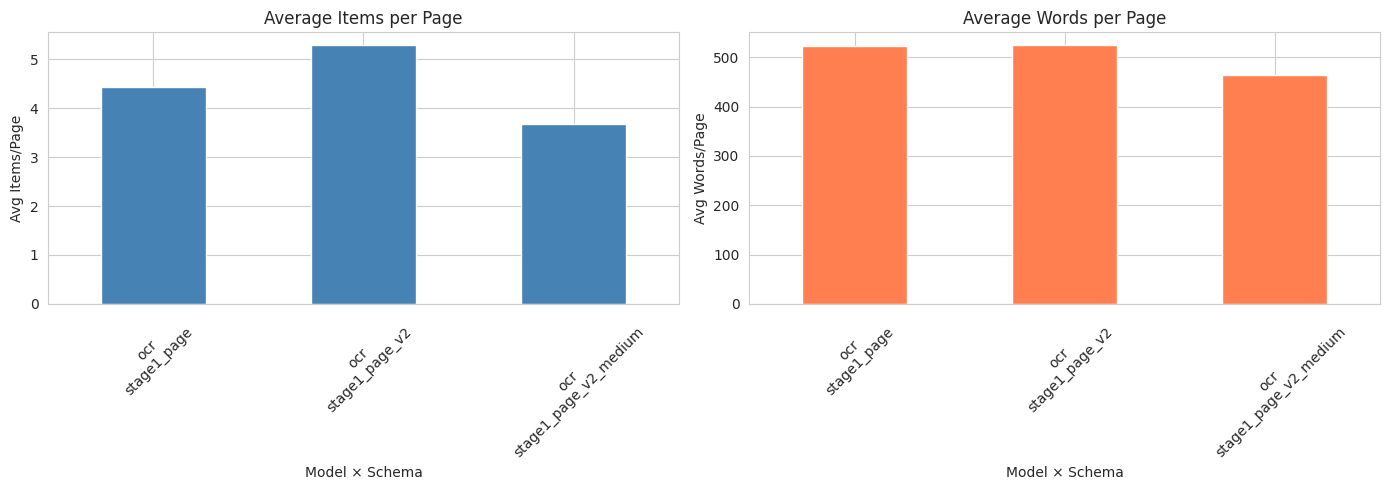


General Statistics Table:


,magazine,model,schema,prompt,avg_items_per_page,empty_pages,avg_words_per_page,total_items
0,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page,None,4.43,1,522.07,62
1,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page_v2,None,5.29,1,524.57,74
2,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page_v2_medium,None,3.67,1,464.89,33




Bag-of-Words Evaluation:



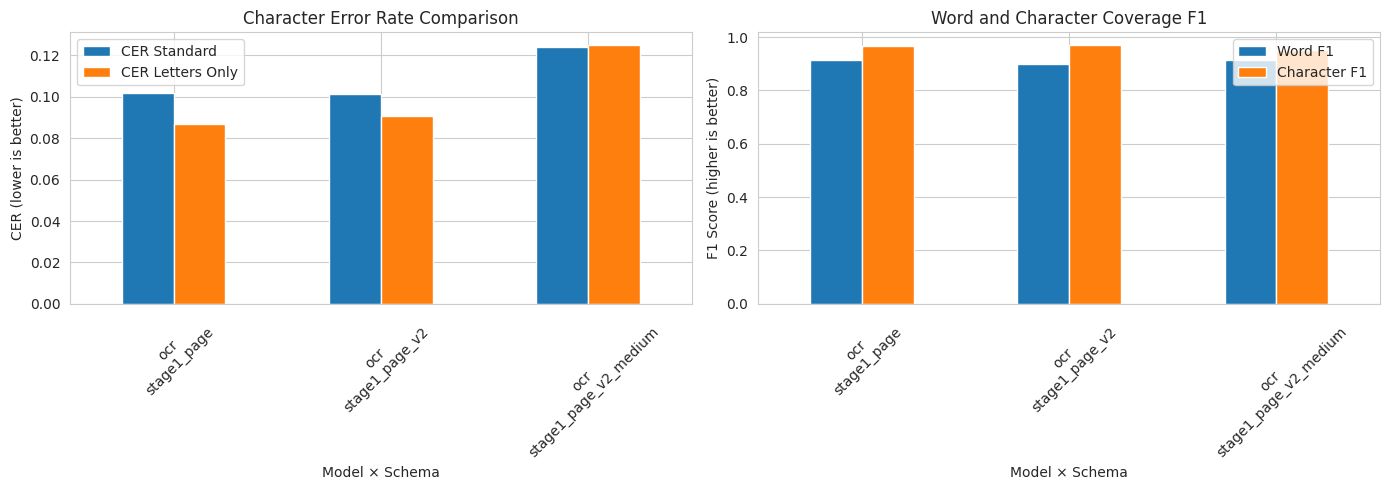


Bag-of-Words Table:


,magazine,model,schema,prompt,reference_source,cer_standard,wer_standard,word_f1,char_f1
0,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page,None,gold,0.102,0.134,0.913,0.967
1,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page_v2,None,gold,0.101,0.149,0.899,0.969
2,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page_v2_medium,None,gold,0.124,0.152,0.915,0.952




Structure-Aware Evaluation:



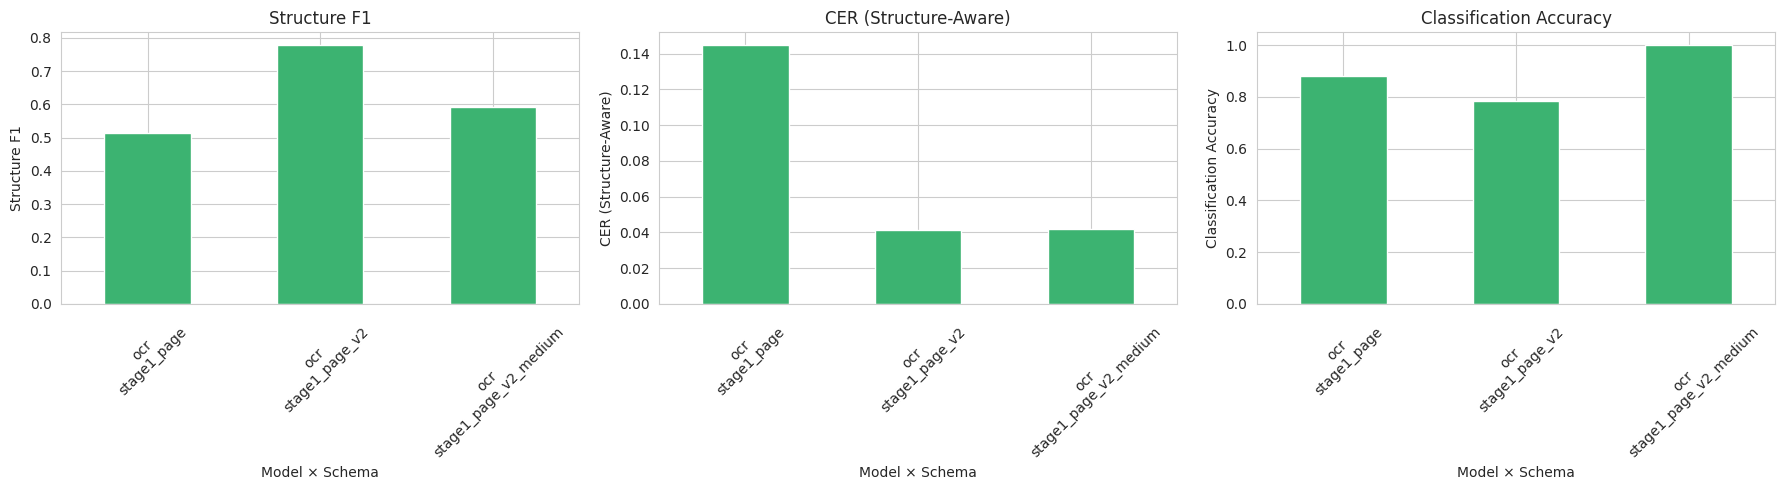

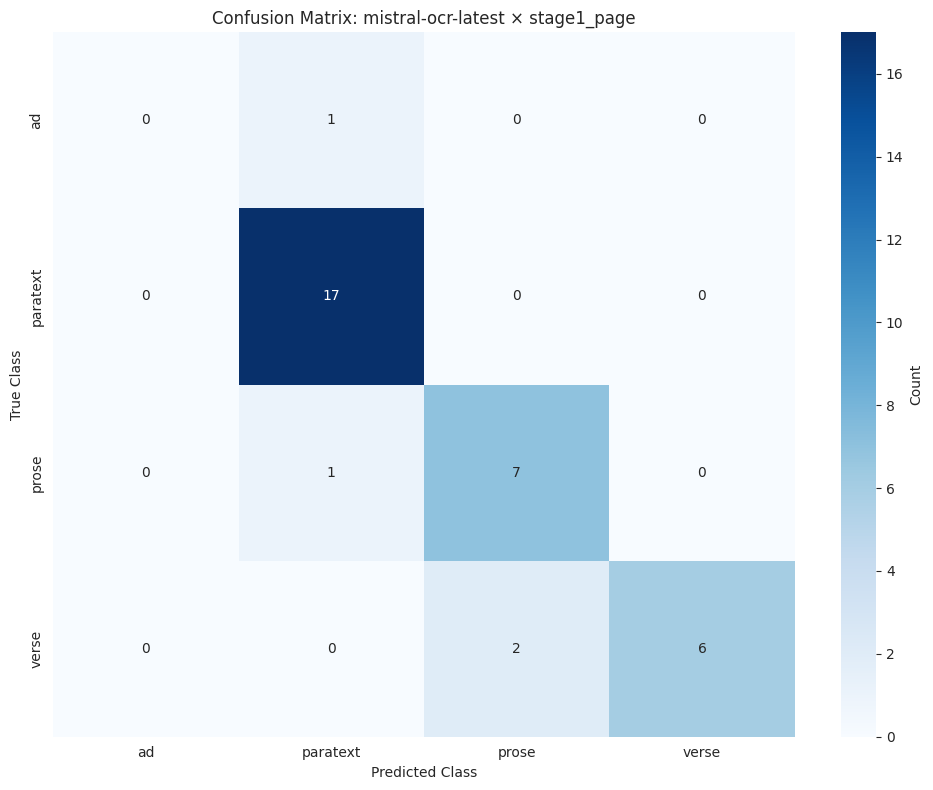


Confusion Matrix for mistral-ocr-latest × stage1_page × None


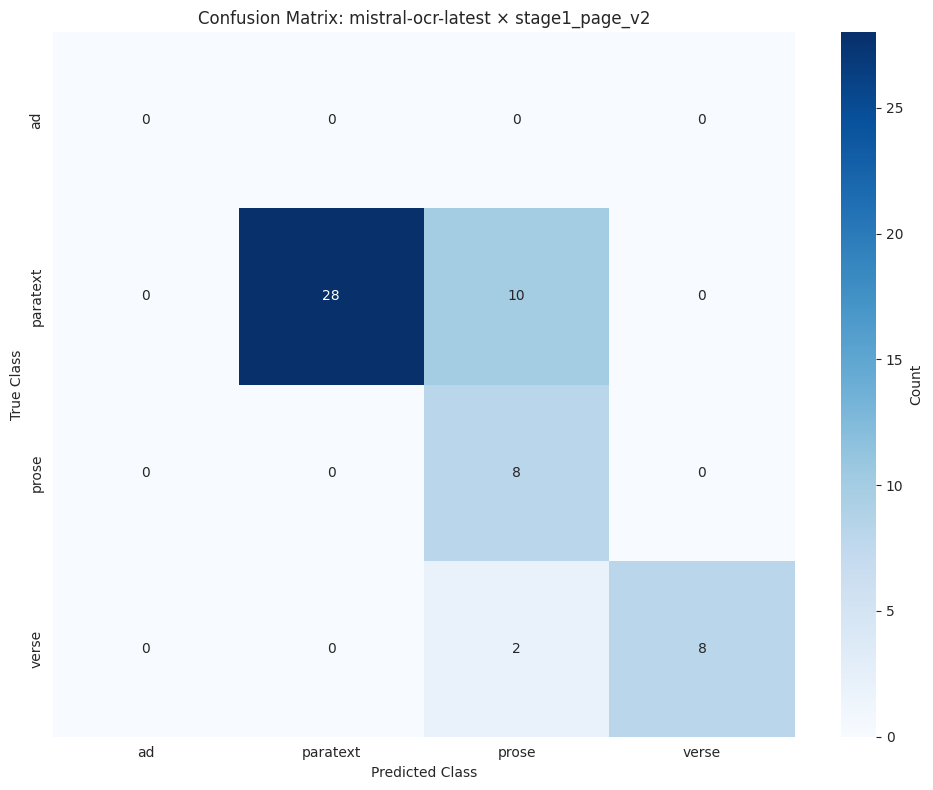


Confusion Matrix for mistral-ocr-latest × stage1_page_v2 × None


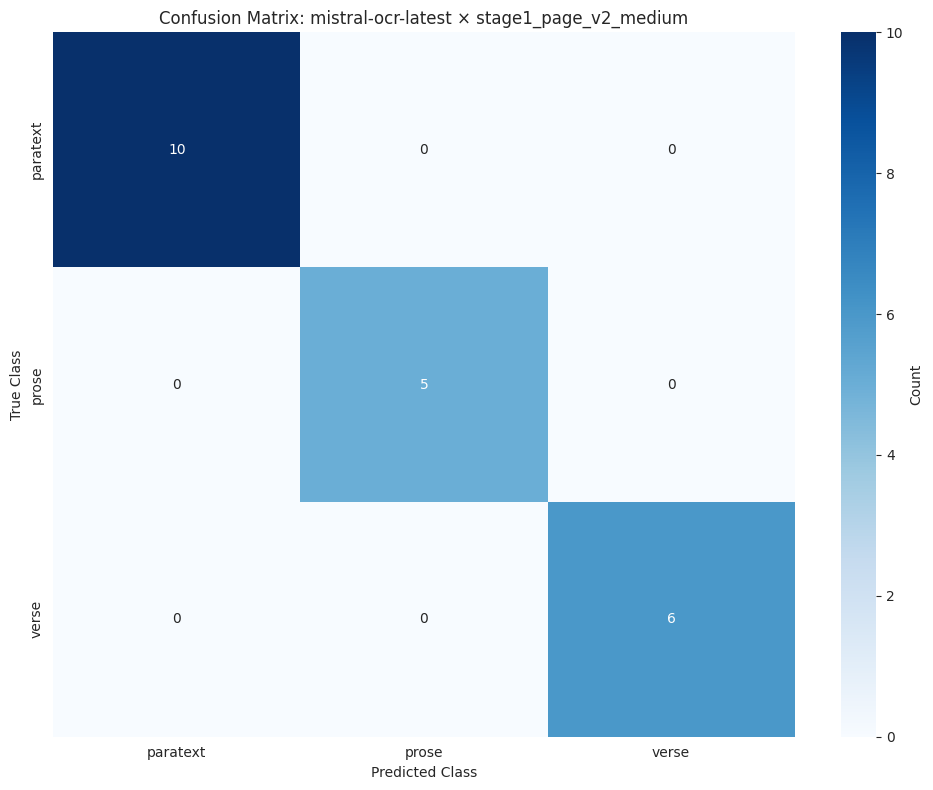


Confusion Matrix for mistral-ocr-latest × stage1_page_v2_medium × None


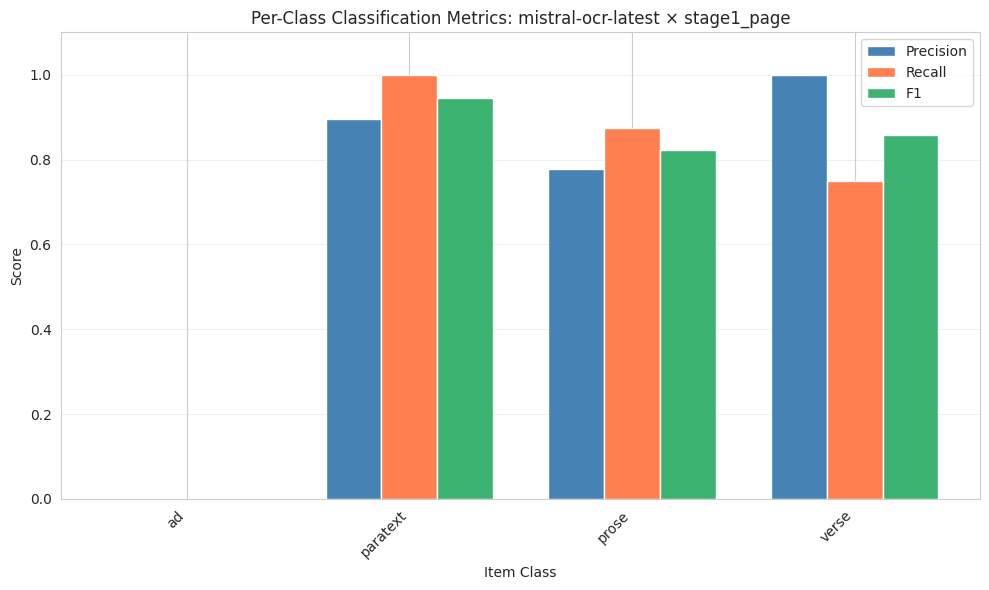


Per-Class Metrics for mistral-ocr-latest × stage1_page × None
      Class  Precision  Recall     F1
0        ad      0.000   0.000  0.000
1  paratext      0.895   1.000  0.944
2     prose      0.778   0.875  0.824
3     verse      1.000   0.750  0.857

Macro Average F1: 0.656
Weighted Average F1: 0.868



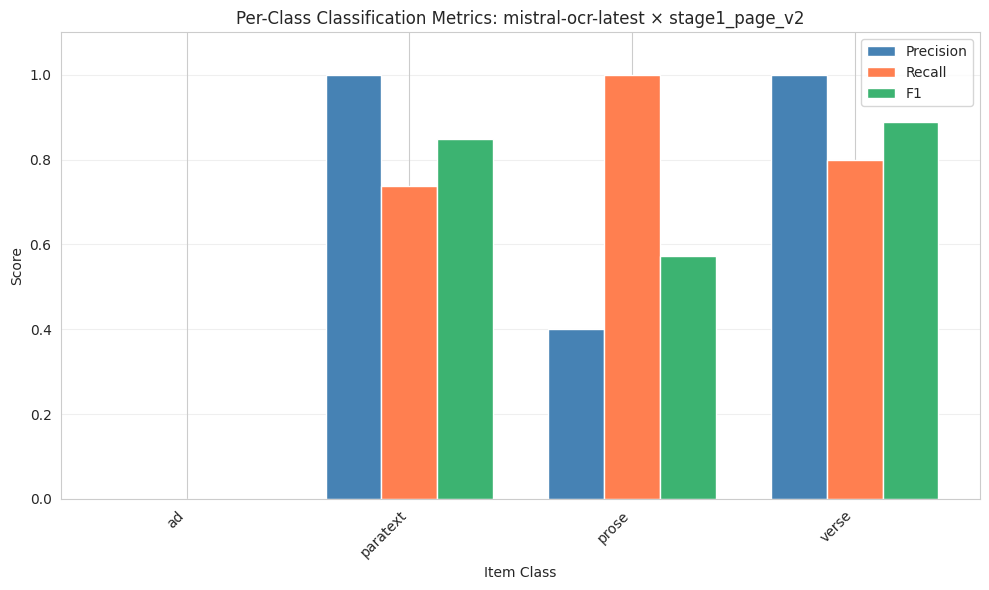


Per-Class Metrics for mistral-ocr-latest × stage1_page_v2 × None
      Class  Precision  Recall     F1
0        ad        0.0   0.000  0.000
1  paratext        1.0   0.737  0.848
2     prose        0.4   1.000  0.571
3     verse        1.0   0.800  0.889

Macro Average F1: 0.577
Weighted Average F1: 0.816



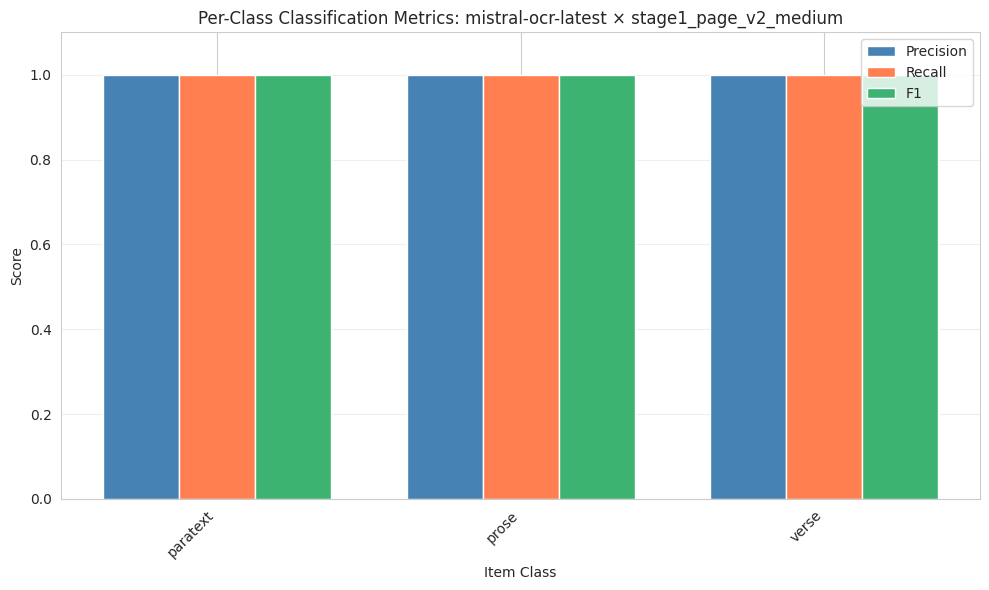


Per-Class Metrics for mistral-ocr-latest × stage1_page_v2_medium × None
      Class  Precision  Recall   F1
0  paratext        1.0     1.0  1.0
1     prose        1.0     1.0  1.0
2     verse        1.0     1.0  1.0

Macro Average F1: 1.000
Weighted Average F1: 1.000


Structure-Aware Summary Table:


,magazine,model,schema,prompt,structure_f1,cer_structure_aware,classification_accuracy,macro_avg_f1
0,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page,None,0.515,0.145,0.882,0.656
1,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page_v2,None,0.778,0.041,0.786,0.577
2,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page_v2_medium,None,0.592,0.042,1.000,1.000




Combined Comparison:


,magazine,model,schema,prompt,avg_items_per_page,cer_standard,word_f1,cer_structure_aware,classification_accuracy
0,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page,None,4.429,0.102,0.913,0.145,0.882
1,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page_v2,None,5.286,0.101,0.899,0.041,0.786
2,La_Plume_bpt6k1185893k_1_10_1889,mistral-ocr-latest,stage1_page_v2_medium,None,3.667,0.124,0.915,0.042,1.000


In [15]:
"""
Summary and Recommendations

Identify best combinations using composite scoring (from 01f).

Composite Scoring: Average of 5 evaluation dimensions:
1. Structure detection (F1)
2. Text quality (1 - CER)
3. Classification accuracy
4. Metadata extraction (avg of title/author F1)
5. Continuation tracking (avg of is/continues F1)
"""

print("\n" + "=" * 60)
print("SUMMARY & RECOMMENDATIONS")
print("=" * 60)
print()

# Calculate composite scores for structure-aware results (from 01f)
if df_structure is not None and len(df_structure) > 0:
    composite_scores = []
    
    for idx, row in df_structure.iterrows():
        scores = []
        score_details = {}
        
        # Dimension 1: Structure detection F1
        if 'structure_f1' in row and pd.notna(row['structure_f1']):
            scores.append(row['structure_f1'])
            score_details['structure_f1'] = row['structure_f1']
        
        # Dimension 2: Text quality (inverse of CER)
        if 'cer_structure_aware' in row and pd.notna(row['cer_structure_aware']):
            text_quality_score = max(0, 1 - row['cer_structure_aware'])
            scores.append(text_quality_score)
            score_details['text_quality'] = text_quality_score
        
        # Dimension 3: Classification accuracy
        if 'classification_accuracy' in row and pd.notna(row['classification_accuracy']):
            scores.append(row['classification_accuracy'])
            score_details['classification'] = row['classification_accuracy']
        
        # Dimension 4: Metadata (average of title and author F1)
        metadata_scores = []
        if 'metadata_title_f1' in row and pd.notna(row['metadata_title_f1']):
            metadata_scores.append(row['metadata_title_f1'])
        if 'metadata_author_f1' in row and pd.notna(row['metadata_author_f1']):
            metadata_scores.append(row['metadata_author_f1'])
        if metadata_scores:
            metadata_avg = sum(metadata_scores) / len(metadata_scores)
            scores.append(metadata_avg)
            score_details['metadata'] = metadata_avg
        
        # Dimension 5: Continuation tracking (average of is_continuation and continues_on_next_page F1)
        continuation_scores = []
        if 'continuation_is_f1' in row and pd.notna(row['continuation_is_f1']):
            continuation_scores.append(row['continuation_is_f1'])
        if 'continuation_continues_f1' in row and pd.notna(row['continuation_continues_f1']):
            continuation_scores.append(row['continuation_continues_f1'])
        if continuation_scores:
            continuation_avg = sum(continuation_scores) / len(continuation_scores)
            scores.append(continuation_avg)
            score_details['continuation'] = continuation_avg
        
        # Calculate composite score (average of available dimensions)
        if scores:
            composite = sum(scores) / len(scores)
            composite_scores.append({
                'magazine': row['magazine'],
                'model': row['model'],
                'schema': row['schema'],
                'prompt': row.get('prompt'),
                'composite_score': composite,
                'num_dimensions': len(scores),
                **score_details
            })
    
    if composite_scores:
        df_composite = pd.DataFrame(composite_scores)
        df_composite = df_composite.sort_values('composite_score', ascending=False)
        
        print("=" * 80)
        print("COMPOSITE SCORING (5 Dimensions)")
        print("=" * 80)
        print()
        print("Ranking by composite score (average of all available dimensions):\n")
        
        for i, row in df_composite.iterrows():
            rank = list(df_composite.index).index(i) + 1
            print(f"{rank}. {row['model']} × {row['schema']} × {row.get('prompt', 'none')}")
            print(f"   Composite Score: {row['composite_score']:.3f} ({row['num_dimensions']} dimensions)")
            
            if 'structure_f1' in row:
                print(f"   - Structure F1: {row['structure_f1']:.3f}")
            if 'text_quality' in row:
                print(f"   - Text Quality: {row['text_quality']:.3f}")
            if 'classification' in row:
                print(f"   - Classification: {row['classification']:.3f}")
            if 'metadata' in row:
                print(f"   - Metadata: {row['metadata']:.3f}")
            if 'continuation' in row:
                print(f"   - Continuation: {row['continuation']:.3f}")
            print()
        
        print("\n✨ OVERALL WINNER (Highest Composite Score):")
        winner = df_composite.iloc[0]
        print(f"   {winner['model']} × {winner['schema']} × {winner.get('prompt', 'none')}")
        print(f"   Score: {winner['composite_score']:.3f}")
        print()

# Identify best combinations based on available metrics
if df_combined is not None and len(df_combined) > 0:
    
    print("\n" + "=" * 60)
    print("BEST BY SPECIFIC METRIC")
    print("=" * 60)
    print()
    
    # Best by general statistics (most items extracted)
    if 'avg_items_per_page' in df_combined.columns:
        best_coverage = df_combined.nlargest(1, 'avg_items_per_page').iloc[0]
        print("Best Coverage (most items extracted):")
        print(f"  {best_coverage['model']} × {best_coverage['schema']} × {best_coverage.get('prompt', 'none')}")
        print(f"  Avg items/page: {best_coverage['avg_items_per_page']:.2f}")
        print()
    
    # Best by bag-of-words CER (lowest error)
    if 'cer_standard' in df_combined.columns:
        valid_cer = df_combined[df_combined['cer_standard'].notna()]
        if len(valid_cer) > 0:
            best_bow = valid_cer.nsmallest(1, 'cer_standard').iloc[0]
            print("Best Text Quality (bag-of-words CER):")
            print(f"  {best_bow['model']} × {best_bow['schema']} × {best_bow.get('prompt', 'none')}")
            print(f"  CER: {best_bow['cer_standard']:.3f}")
            print()
    
    # Best by word coverage F1
    if 'word_f1' in df_combined.columns:
        valid_word = df_combined[df_combined['word_f1'].notna()]
        if len(valid_word) > 0:
            best_word = valid_word.nlargest(1, 'word_f1').iloc[0]
            print("Best Word Coverage F1:")
            print(f"  {best_word['model']} × {best_word['schema']} × {best_word.get('prompt', 'none')}")
            print(f"  Word F1: {best_word['word_f1']:.3f}")
            print()
    
    # Best by structure F1
    if 'structure_f1' in df_combined.columns:
        valid_struct = df_combined[df_combined['structure_f1'].notna()]
        if len(valid_struct) > 0:
            best_struct = valid_struct.nlargest(1, 'structure_f1').iloc[0]
            print("Best Structure Detection F1:")
            print(f"  {best_struct['model']} × {best_struct['schema']} × {best_struct.get('prompt', 'none')}")
            print(f"  Structure F1: {best_struct['structure_f1']:.3f}")
            print()
    
    # Best by structure-aware CER
    if 'cer_structure_aware' in df_combined.columns:
        valid_sa = df_combined[df_combined['cer_structure_aware'].notna()]
        if len(valid_sa) > 0:
            best_structure = valid_sa.nsmallest(1, 'cer_structure_aware').iloc[0]
            print("Best Structure-Aware Text Quality (CER):")
            print(f"  {best_structure['model']} × {best_structure['schema']} × {best_structure.get('prompt', 'none')}")
            print(f"  CER: {best_structure['cer_structure_aware']:.3f}")
            print()
    
    # Best classification
    if 'classification_accuracy' in df_combined.columns:
        valid_class = df_combined[df_combined['classification_accuracy'].notna()]
        if len(valid_class) > 0:
            best_class = valid_class.nlargest(1, 'classification_accuracy').iloc[0]
            print("Best Classification Accuracy:")
            print(f"  {best_class['model']} × {best_class['schema']} × {best_class.get('prompt', 'none')}")
            print(f"  Accuracy: {best_class['classification_accuracy']:.3f}")
            print()
    
    # Best weighted F1 (if available)
    if 'weighted_avg_f1' in df_combined.columns:
        valid_weighted = df_combined[df_combined['weighted_avg_f1'].notna()]
        if len(valid_weighted) > 0:
            best_weighted = valid_weighted.nlargest(1, 'weighted_avg_f1').iloc[0]
            print("Best Weighted Classification F1:")
            print(f"  {best_weighted['model']} × {best_weighted['schema']} × {best_weighted.get('prompt', 'none')}")
            print(f"  Weighted F1: {best_weighted['weighted_avg_f1']:.3f}")
            print()

print("\n" + "=" * 60)
print("Recommendations:")
print("=" * 60)
print()
print("For production use, select configuration based on your priorities:")
print("  - Highest coverage: Best for completeness")
print("  - Lowest CER: Best for text accuracy")
print("  - Best classification: Best for structured data extraction")
print("  - Highest composite: Best overall balanced performance")
print()
print("Review:")
print("  - Composite scores to identify overall best configuration")
print("  - Per-class metrics and confusion matrices for classification insights")
print("  - Schema families to understand continuation field impact")
     


SUMMARY & RECOMMENDATIONS

COMPOSITE SCORING (5 Dimensions)

Ranking by composite score (average of all available dimensions):

1. mistral-ocr-latest × stage1_page_v2_medium × None
   Composite Score: 0.850 (3 dimensions)
   - Structure F1: 0.592
   - Text Quality: 0.958
   - Classification: 1.000

2. mistral-ocr-latest × stage1_page_v2 × None
   Composite Score: 0.841 (3 dimensions)
   - Structure F1: 0.778
   - Text Quality: 0.959
   - Classification: 0.786

3. mistral-ocr-latest × stage1_page × None
   Composite Score: 0.751 (3 dimensions)
   - Structure F1: 0.515
   - Text Quality: 0.855
   - Classification: 0.882


✨ OVERALL WINNER (Highest Composite Score):
   mistral-ocr-latest × stage1_page_v2_medium × None
   Score: 0.850


BEST BY SPECIFIC METRIC

Best Coverage (most items extracted):
  mistral-ocr-latest × stage1_page_v2 × None
  Avg items/page: 5.29

Best Text Quality (bag-of-words CER):
  mistral-ocr-latest × stage1_page_v2 × None
  CER: 0.101

Best Word Coverage F1:
  mi

In [ ]:
# """
# Export Results (Optional)

# Export evaluation results to CSV and JSON files.
# Run this cell only if you want to save results to disk.
# """

# print("\n" + "=" * 60)
# print("EXPORT RESULTS")
# print("=" * 60)
# print()

# output_dir = PREDICTIONS / "evaluation_results"
# output_dir.mkdir(parents=True, exist_ok=True)

# # Export to CSV
# if df_combined is not None:
#     csv_path = output_dir / "evaluation_results.csv"
#     df_combined.to_csv(csv_path, index=False)
#     print(f"✓ Saved combined results: {csv_path}")

# if df_general is not None:
#     csv_path = output_dir / "general_statistics.csv"
#     df_general.to_csv(csv_path, index=False)
#     print(f"✓ Saved general statistics: {csv_path}")

# if df_bow is not None:
#     csv_path = output_dir / "bag_of_words.csv"
#     df_bow.to_csv(csv_path, index=False)
#     print(f"✓ Saved bag-of-words: {csv_path}")

# if df_structure is not None:
#     csv_path = output_dir / "structure_aware.csv"
#     df_structure.to_csv(csv_path, index=False)
#     print(f"✓ Saved structure-aware: {csv_path}")

# # Export composite scores (from 01f)
# if 'df_composite' in locals() and df_composite is not None:
#     csv_path = output_dir / "composite_scores.csv"
#     df_composite.to_csv(csv_path, index=False)
#     print(f"✓ Saved composite scores: {csv_path}")

# # Export BnF comparison
# if bnf_comparison_results:
#     df_bnf = pd.DataFrame(bnf_comparison_results)
#     csv_path = output_dir / "bnf_comparison.csv"
#     df_bnf.to_csv(csv_path, index=False)
#     print(f"✓ Saved BnF comparison: {csv_path}")

# # Export schema family comparison
# if schema_family_results:
#     df_families = pd.DataFrame(schema_family_results)
#     csv_path = output_dir / "schema_family_comparison.csv"
#     df_families.to_csv(csv_path, index=False)
#     print(f"✓ Saved schema family comparison: {csv_path}")

# # Export to JSON
# if df_combined is not None:
#     json_path = output_dir / "evaluation_results.json"
#     df_combined.to_json(json_path, orient='records', indent=2)
#     print(f"✓ Saved JSON results: {json_path}")

# print()
# print("=" * 60)
# print("EXPORT COMPLETE")
# print("=" * 60)
# print(f"\nResults saved to: {output_dir}")
# print()
# print("Files exported:")
# print("  - evaluation_results.csv/json - Combined results across all evaluation types")
# print("  - general_statistics.csv - Internal quality metrics")
# print("  - bag_of_words.csv - Text-level comparison (CER/WER + word/char coverage)")
# print("  - structure_aware.csv - Item-level evaluation with 5 dimensions")
# print("  - composite_scores.csv - Ranked by composite score (01f)")
# print("  - bnf_comparison.csv - Mistral vs BnF OCR comparison (01d)")
# print("  - schema_family_comparison.csv - Within/cross-family analysis (01f)")